In [1]:
# Importamos las librerias necesarias para trabajar
from statsmodels.regression.linear_model import yule_walker
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from numpy.fft import fft, fftfreq, fftshift
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy import signal
from sqlalchemy import create_engine
from numpy.linalg import pinv
from matplotlib import cm
from datetime import time
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sp
import mysql.connector
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import copy
import sklearn

# Seteamos el estilo de los graficos
sns.set(style="whitegrid")

# Configuramos los graficos con latex
plt.rc('text', usetex=True)

# Funcion para la metrica de la trayectoria
def error_trayectoria(vector):
    '''
    Se calcula una norma de error como la diferencia entre la prediccion y la medicion
    real para un tiempo t. Se utilizara la norma euclidiana
    '''
    y_predict = vector['y+1':'y+6']
    y_real = vector['y']
    error = (y_predict - y_real) ** 2
    error = sum(error) / len(error)
    return np.sqrt(error)

def phi_X(R_X, gamma, Ts=5 * 60):
    arg_max = R_X.argmax()
    R_X_wind = R_X[arg_max - gamma: arg_max + gamma + 1]
    wind = np.hanning(len(R_X_wind))
    phi_X = fft(R_X_wind * wind)
    freq = fftfreq(len(phi_X), Ts)
    phi_X = pd.Series(phi_X, index=freq)
    phi_X = phi_X[freq > 0]
    return phi_X

def lowPassFilter(serie, window=5):
    serie_out = list()
    serie_out.append(serie[0])
    for i in range(1,len(serie)):
        values = serie[:i]
        value= values[-window:]
        serie_out.append(value.mean())
    return np.array(serie_out)

def periodograma(serie, Ts=5*60):
    N = len(serie)
    freq = fftfreq(N, Ts)
    S = fft(serie, norm='ortho')
    S_N = abs(S) ** 2
    S_N = pd.Series(S_N, index=freq)
    return S_N[freq > 0]

def arx(data, orders, Q=None):
    '''
    Modelo ARX para un sistema MISO
    '''
    # Creamos los parametros del modelo
    N = len(data)            # int:  Tamano total de los datos
    na = orders[0]           # int:  Orden de la regresion
    Nb = orders[1:]          # list: Ordenes de las entradas exogenas
    max_order = max(orders)  # int:  Orden maximo entre la regresion y las entradas exogenas
    d = sum(orders)          # int:  Tamano de los vectores de regresion
    
    # Separamos las series de tiempo en salida y entradas
    y = data.iloc[:,0].to_numpy()     # Salida:  tamano N x 1
    y = y.reshape(len(y), 1)
    U = data.iloc[:,1:].to_numpy()    # Entrada: tamano N x len(Nb)     
    
    # Verificamos que el tamano de los ordenes de las entradas tenga el mismo tamano de las series
    # de tiempo de las entradas
    if len(Nb) != U.shape[1]:
        print('Problemas de tamano: Tamano incorrecto entre Nb ({}) y series de entradas ({})'
              .format(len(Nb), U.shape[1]))
        return
    
    
    # Generamos el vector de salida de la prediccion
    Y_N = y[max_order:]    # Tamano: N - max_order x 1
    
    # Generamos la matriz de datos
    Phi_N = np.zeros([N-max_order, d])  # Tamano: N - max_order  x d 
    
    # Iteramos para llenar la matriz con la variable autoregresiva
    for i in range(na):
        Phi_N[:,i] = - y[max_order - i - 1:-i - 1].T
    
    # Iteramos para llenar la matriz con las variables de entradas
    
    col_count = na   # Contador para almacenar el indice de la columna donde guardar los datos en Phi_N
    for j in range(len(Nb)):    # Iteramos para cada serie de entrada
        nb = Nb[j]              # Orden de la serie utilizada
        u_actual = U[:,j]       # Extraemos la columna utilizada
        for i in range(nb):
            Phi_N[:, col_count] = u_actual[max_order - i - 1:-i - 1]
            col_count += 1

    # Si la matriz Q no esta especificada, calculamos el vector theta de parametros con la pseudo inversa
    if Q is None:
        theta_N = np.dot(np.linalg.pinv(Phi_N), Y_N)
        return theta_N
    # En caso contrario, se utiliza la formula que utiliza la inversa explicida y la matriz Q
    else:
        Q = Q[max_order:, max_order:]
        Phi_Q_Phi = np.dot(np.dot(Phi_N.T, Q), Phi_N)
        Phi_Q_Y = np.dot(np.dot(Phi_N.T, Q), Y_N)
        theta_N = np.dot(np.linalg.inv(Phi_Q_Phi), Phi_Q_Y)
        return theta_N
    
def k_step_predict(data, orders, theta, k=1):
    # Creamos los parametros del modelo
    N = len(data)            # int:  Tamano total de los datos
    na = orders[0]           # int:  Orden de la regresion
    Nb = orders[1:]          # list: Ordenes de las entradas exogenas
    max_order = max(orders)  # int:  Orden maximo entre la regresion y las entradas exogenas
    d = sum(orders)          # int:  Tamano de los vectores de regresion
    
    # Separamos las series de tiempo en salida y entradas
    y = data.iloc[:,0].to_numpy()     # Salida:  tamano N x 1
    y = y.reshape(len(y), 1)
    U = data.iloc[:,1:].to_numpy()    # Entrada: tamano N x len(Nb)
    
    # Verificamos que el tamano de los ordenes de las entradas tenga el mismo tamano de las series
    # de tiempo de las entradas
    if len(Nb) != U.shape[1]:
        print('Problemas de tamano: Tamano incorrecto entre Nb ({}) y series de entradas ({})'
              .format(len(Nb), U.shape[1]))
        return
    
    
    N_columns = N - max_order - k + 1    # Numero de columnas de salida. Desde n+k hasta N
    
    # Generamos las matrices de regresion para cada variable
    phi_y = np.zeros([na + k, N_columns]);
    
    # iteramos para llenar la matriz de y
    for i in range(na):
        phi_y[i + k,:] = -y[na-i-1:-i-k].T
    
    phi_u_matrix = list()
    
    count = 0
    for j in range(len(Nb)):
        nb = Nb[j]
        phi_u = np.zeros([nb + k, N_columns]);
        u = U[:,j]
        for i in range(nb + k):
            phi_u[i,:] = u[nb + k -i-1:N-i]
        phi_u_matrix.append(phi_u)
        
    for i in range(k):
        phi_u_matrix_buff = list()
        for phi_u in phi_u_matrix:
            phi_u_matrix_buff.append(phi_u[k - i:k + max_order - i, :])
        phi_u = np.concatenate(phi_u_matrix_buff)
        phi = np.concatenate([phi_y[k - i:k + max_order - i, :], phi_u])
        phi_y[k - i - 1, :] = - np.dot(theta.T, phi);
    
    columns_name = ['k+{}'.format(i) for i in range(1, k+1)]
    predict = pd.DataFrame(index=data.index, columns=columns_name)
    predict = predict.iloc[max_order:,:]
    predict.iloc[:-k+1,:] = np.flip(-phi_y[0:k,:].T, axis=1)
    
    for i in range(len(columns_name)):
        column = columns_name[i]
        predict[column] = predict[column].shift(i)
    
    return predict

In [2]:
# Extraemos la salida
mydb = mysql.connector.connect(
    host='localhost',
    user='root',
    password='7461143',
    database='output_y'
)

# Extraemos la informacion en un dataframe
y = pd.read_sql("SELECT datetime, y FROM y1", mydb)   # Cargamos todos los datos
y.set_index('datetime', inplace=True)                 # Definimos datetime como indice
y.sort_index(inplace=True)                            # Ordenamos en base a datetime

# Extraemos las entradas
mydb = mysql.connector.connect(
    host='localhost',
    user='root',
    password='7461143',
    database='input_u'
)

# Extraemos la informacion de la entrada de los bolos
u_bolo = pd.read_sql("SELECT * FROM u_bolo", mydb)    # Cargamos todos los datos
u_bolo.set_index('datetime', inplace=True)            # Definimos el datetime como indice
u_bolo.sort_index(inplace=True)                       # Ordenamos los datos en base a datetime

# Extraemos la informacion de la entrada de los bolos
u_meal = pd.read_sql("SELECT * FROM u_meal", mydb)    # Cargamos todos los datos
u_meal.set_index('datetime', inplace=True)            # Definimos el datetime como indice
u_meal.sort_index(inplace=True)                       # Ordenamos los datos en base a datetime

# Extraemos la informacion de la entrada de los bolos
u_holter = pd.read_sql("SELECT * FROM u_holter", mydb)  # Cargamos todos los datos
u_holter.set_index('datetime', inplace=True)            # Definimos el datetime como indice
u_holter.sort_index(inplace=True)                       # Ordenamos los datos en base a datetime

# Extraemos la informacion de la entrada de los bolos
u_equivital = pd.read_sql("SELECT * FROM u_equivital", mydb)    # Cargamos todos los datos
u_equivital.set_index('datetime', inplace=True)                 # Definimos el datetime como indice
u_equivital.sort_index(inplace=True)                            # Ordenamos los datos en base a datetime

# Unimos los datos
data = y.join([u_bolo, u_meal, u_holter, u_equivital])

# Mostramos los resultados
data.index.freq = pd.infer_freq(data.index)

print('Tamano de la tabla: {} filas y {} columnas'.format(data.shape[0], data.shape[1]))
print('Tiempo del estudio:')
print(' - Inicio  : {}'.format(str(data.index[0])))
print(' - Final   : {}'.format(str(data.index[-1])))
print(' - Duración: {}'.format(str(data.index[-1] - data.index[0])))
data.head(3)

Tamano de la tabla: 1728 filas y 22 columnas
Tiempo del estudio:
 - Inicio  : 2020-01-24 17:00:00
 - Final   : 2020-01-30 16:55:00
 - Duración: 5 days 23:55:00


,y,u_bolo_delta,u_bolo_gauss,u_bolo_hov,u_bolo_biexp,u_bolo_rem,u_meal_delta,u_meal_gauss,u_meal_hov,u_meal_rem,...,u_holter_HR,u_holter_mean,u_equivital_HR,u_equivital_BR,u_equivital_temp,u_equivital_RR,u_equivital_BW,u_equivital_lat_acc,u_equivital_long_acc,u_equivital_ver_acc
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-24 17:00:00,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24 17:05:00,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24 17:10:00,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data['u_equivital_lat_acc'].dropna()

datetime
2020-01-24 19:15:00    846.974245
2020-01-24 19:20:00    811.734677
2020-01-24 19:25:00   -123.464496
2020-01-24 19:30:00   -140.348711
2020-01-24 19:35:00   -123.702109
                          ...    
2020-01-30 09:30:00    926.527773
2020-01-30 09:35:00    926.507969
2020-01-30 09:40:00    926.507969
2020-01-30 09:45:00    925.866142
2020-01-30 14:35:00    837.439525
Name: u_equivital_lat_acc, Length: 457, dtype: float64

In [4]:
# Abrimos la base de datos
mydb = mysql.connector.connect(
    host='localhost',
    user='root',
    password='7461143',
    database='datos_brutos'
)

# Extraemos la informacion en un dataframe
df_eq = pd.read_sql("SELECT * FROM equivital_5", mydb)   # Cargamos todos los datos 
df_eq.drop('id', axis=1, inplace=True)                   # Eliminamos el indice
df_eq.set_index('datetime', inplace=True)                # Definimos datetime como indice
df_eq.sort_index(inplace=True)                           # Ordenamos en base a datetime
# Mostramos los resultados
print('Tamano de la tabla: {} filas y {} columnas'.format(df_eq.shape[0], df_eq.shape[1]))
df_eq.head(5)

Tamano de la tabla: 4359789 filas y 10 columnas


,HR,BR,Skin_Temperature_IR_Thermometer,HR_Confidence,BR_Confidence,Lateral_Acc,Longitudinal_Acc,Vertical_Acc,Breathing_Wave,Inter_Beat_Interval
datetime,,,,,,,,,,
2020-01-24 19:18:54.043,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-3.9,0.0,NaN
2020-01-24 19:18:54.082,NaN,NaN,NaN,NaN,NaN,3.9,-3.9,-3.9,0.0,NaN
2020-01-24 19:18:54.121,NaN,NaN,NaN,NaN,NaN,-3.9,-3.9,-11.7,0.0,NaN
2020-01-24 19:18:54.160,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-3.9,0.0,NaN
2020-01-24 19:18:54.199,NaN,NaN,NaN,NaN,NaN,0.0,-3.9,-7.8,0.0,NaN


In [5]:
df_acc = df_eq[['Lateral_Acc','Longitudinal_Acc','Vertical_Acc']]
df_acc.head(5)

,Lateral_Acc,Longitudinal_Acc,Vertical_Acc
datetime,,,
2020-01-24 19:18:54.043,0.0,0.0,-3.9
2020-01-24 19:18:54.082,3.9,-3.9,-3.9
2020-01-24 19:18:54.121,-3.9,-3.9,-11.7
2020-01-24 19:18:54.160,0.0,0.0,-3.9
2020-01-24 19:18:54.199,0.0,-3.9,-7.8


## ENMO: Euclidean norm minus one

In [17]:
def mean_1(segmento):
    segmento = segmento.dropna()
    n = len(segmento)
    threshold = 7400
    if n > threshold:
        return np.mean(segmento)
    else:
        return np.nan
    
def euclidean_norm_minus_one(df):
    # Copiamos el datafame de entrada
    df = copy.copy(df)
    # Calculamos la norma euclidiana
    r = np.sqrt(df.iloc[:,0] ** 2 + df.iloc[:,1] ** 2 + df.iloc[:,2] ** 2)
    r = r - 1
    r[r<0] = 0
    return r.resample('5T').apply(mean_1)   # retornamos el promedio dentro de una ventana de 5 minutos
    
ENMO = euclidean_norm_minus_one(df_acc.dropna())

## VMC: Vector Magnitude count

In [7]:
def mean_1(segmento):
    segmento = segmento.dropna()
    n = len(segmento)
    threshold = 7400
    if n > threshold:
        return np.mean(segmento)
    else:
        return np.nan

def vector_magnitude_count(df):
    # Copiamos el datafame de entrada
    df = copy.copy(df)
    # Calculamos la norma euclidiana
    r = np.sqrt(df.iloc[:,0] ** 2 + df.iloc[:,1] ** 2 + df.iloc[:,2] ** 2)
    
    # Realizamos un remuestreo de 40ms para tener una tasa uniforme
    r = r.resample('40mS').mean()
    
    # Calculamos el promedio de en ventanas de 5 minutos
    grupo = r.resample('5T')              # Agrupamos los grupos en ventanas de 5 minutos
    r_bar = grupo.apply(mean_1)           # Utilizamos una regla de agrupacion de promedio
    r_bar = r_bar.resample('40mS').mean() # Agrupamos los datos en lazos de 40 ms (sobremestreo)
    # Interpolamos los datos con un holding de datos con un maximo de 5 minutos (5 min * 60 seg * fs puntos)
    r_bar.interpolate(metod='pad', limit = 5 * 60 * 25, inplace=True)
    
    # Calculamos el VCM
    r_diff = np.abs(r - r_bar)            # Calculamos el valor absoluto de la diferencia
    return r_diff.resample('5T').mean()   # retornamos el promedio dentro de una ventana de 5 minutos
    
VCM = vector_magnitude_count(df_acc.dropna())

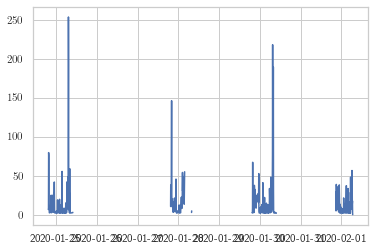

In [8]:
plt.plot(VCM)

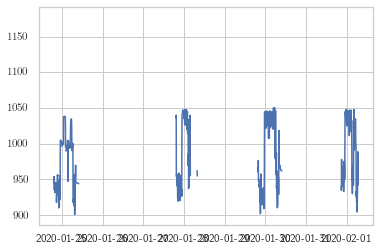

In [9]:
plt.plot(ENMO)